In [1]:
import math

import torch
from scipy.special import lambertw
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle, Circle

In [3]:
plt.style.use('scientific')

In [4]:
from rsnn.spike_sequences.sampling import backward_filtering_forward_sampling
from rsnn.spike_sequences.utils import is_predictable
from rsnn.ikie.ikie import compute_box_prior, compute_posterior, compute_m_ary_prior
from rsnn.ikie.utils import compute_observation_matrix, get_mask_refractory_period, get_mask_around_firing, get_mask_at_firing
from rsnn.rsnn.utils import compute_input_matrix

In [5]:
delays = torch.load('delays.pt')
origins = torch.load('origins.pt')
weights = torch.load('weights_box.pt')
spike_sequences = torch.load("spike_sequences.pt")

In [6]:
L, N = spike_sequences.size()
K = delays.size(1)
N, L, K

(500, 500, 200)

In [27]:
Nr, dt = 20, 5
theta = 1
beta = -Nr / lambertw(-1e-2 / math.exp(1), -1).real
impulse_response = lambda t_: (t_>0) * t_ / beta * torch.exp(1 - t_ / beta)

In [8]:
mask_at_firing = get_mask_at_firing(spike_sequences)
mask_refractory_period = get_mask_refractory_period(spike_sequences, Nr, dt)
mask_around_firing = get_mask_around_firing(spike_sequences, dt)

# Is memorization perfect?

In [24]:
H = compute_input_matrix(spike_sequences, delays, origins, Nr, impulse_response)
y = (H@weights.view(L, 1, K, 1)).squeeze()

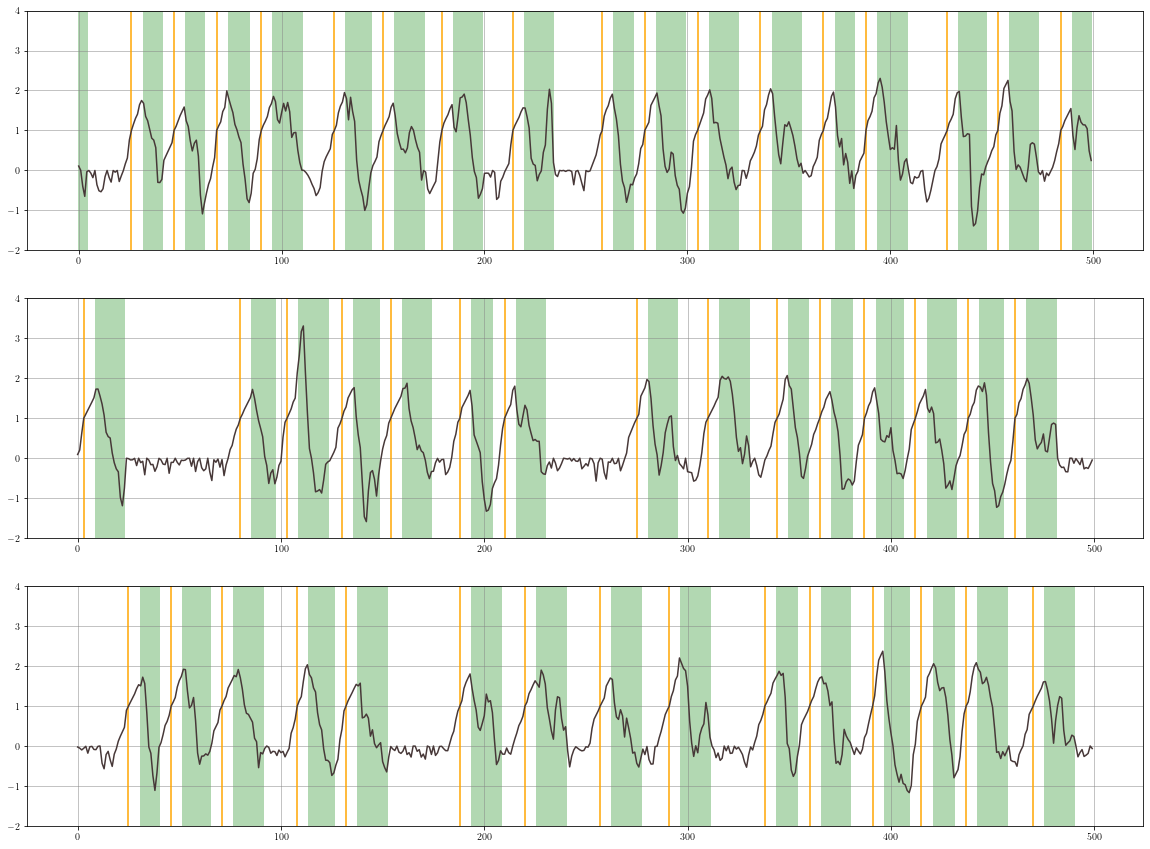

In [28]:
time = torch.arange(N)

fig, axes = plt.subplots(3, figsize=(20, 15))
for l in range(3):
    for n in range(N):
        if mask_at_firing[l,n]:
                axes[l].axvline(n, color="orange")
        if (mask_refractory_period*~mask_around_firing)[l,n]:
            axes[l].add_patch(Rectangle((n-0.5,-2), 1, 6, facecolor="green", alpha=0.3))
    
    _ = axes[l].plot(time, y[l])
    _ = axes[l].set_ylim(-2,4)

# What about temporal super-resolution?

In [22]:
impulse_response_10 = lambda t_: impulse_response(t_/10)
firing_sequences_10 = torch.cat((spike_sequences.view(L,N,1), torch.zeros(L, N, 9,dtype=torch.bool)), dim=-1).view(L, -1)
H_10 = compute_input_matrix(firing_sequences_10, 10*delays, origins, 10*Nr, impulse_response_10)
y_10 = (H_10@weights.view(L, 1, K, 1)).squeeze()

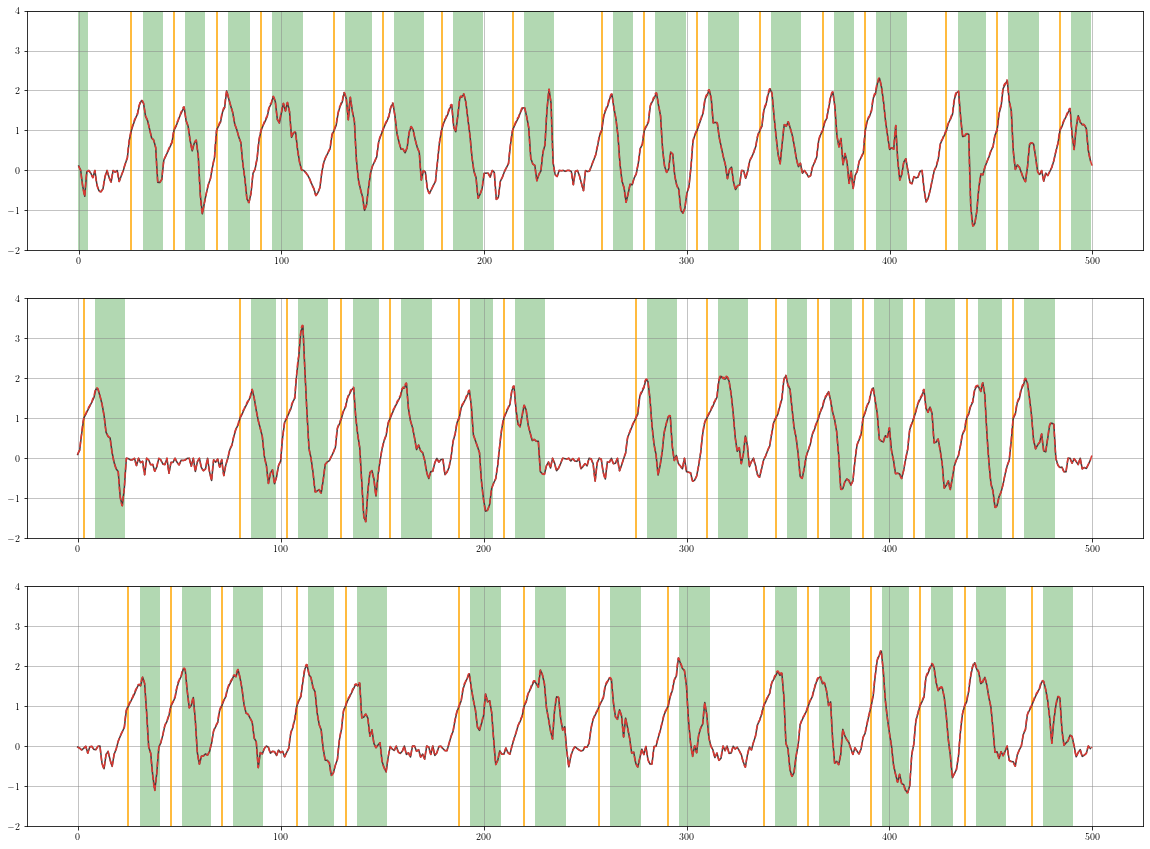

In [29]:
time = torch.arange(N)
time_10 = torch.arange(N*10)/10

fig, axes = plt.subplots(3, figsize=(20, 15))
for l in range(3):
    for n in range(N):
        if mask_at_firing[l,n]:
                axes[l].axvline(n, color="orange")
        if (mask_refractory_period*~mask_around_firing)[l,n]:
            axes[l].add_patch(Rectangle((n-0.5,-2), 1, 6, facecolor="green", alpha=0.3))
        
    _ = axes[l].plot(time, y[l])
    _ = axes[l].plot(time_10, y_10[l],linestyle="dashed")
    _ = axes[l].set_ylim(-2,4)

# Crazy neuron

In [16]:
crazy_firing_sequences = spike_sequences.clone()
crazy_firing_sequences[42] = True

crazy_H = compute_input_matrix(crazy_firing_sequences, delays, origins, Nr, impulse_response)
crazy_y = (crazy_H@weights.view(L, 1, K, 1)).squeeze()

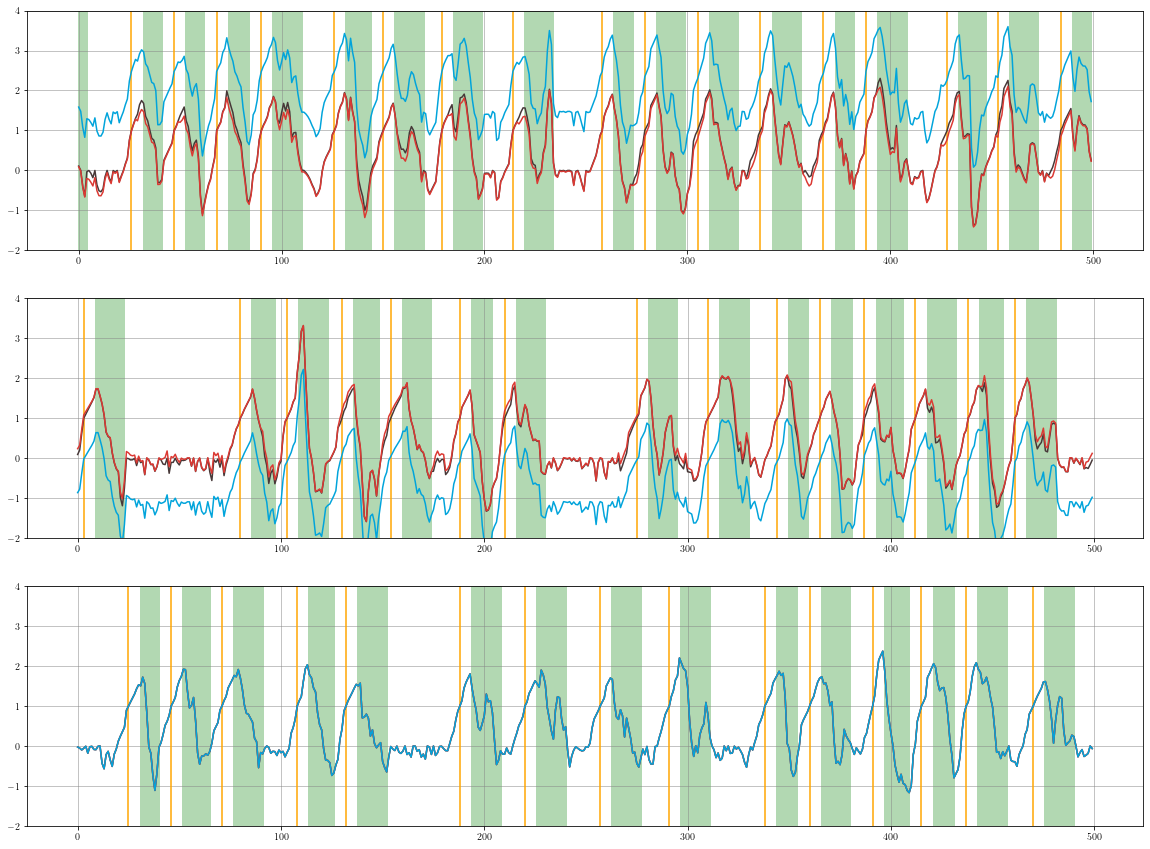

In [17]:
time = torch.arange(N)

fig, axes = plt.subplots(3, figsize=(20, 15))
for l in range(3):
    for n in range(N):
        if mask_at_firing[l,n]:
                axes[l].axvline(n, color="orange")
        if (mask_refractory_period*~mask_around_firing)[l,n]:
            axes[l].add_patch(Rectangle((n-0.5,-2), 1, 6, facecolor="green", alpha=0.3))
    offset = weights[l, origins[l] == 42].sum() * torch.exp(torch.ones(1)) * beta
    _ = axes[l].plot(time, y[l])
    _ = axes[l].plot(time, crazy_y[l] - offset)
    _ = axes[l].plot(time, crazy_y[l])
    _ = axes[l].set_ylim(-2,4)

# Dead neuron

In [18]:
dead_firing_sequences = spike_sequences.clone()
dead_firing_sequences[42] = False

dead_H = compute_input_matrix(dead_firing_sequences, delays, origins, Nr, impulse_response)
dead_y = (dead_H@weights.view(L, 1, K, 1)).squeeze()

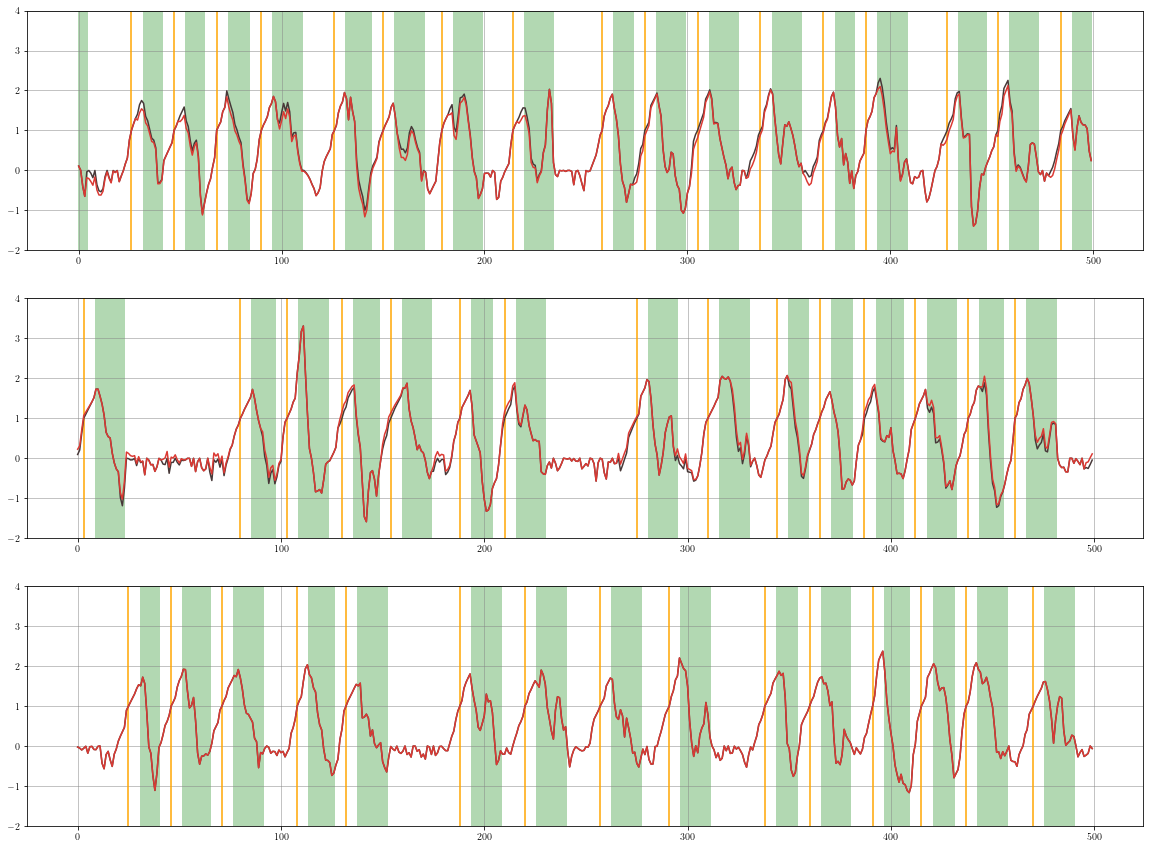

In [19]:
time = torch.arange(N)

fig, axes = plt.subplots(3, figsize=(20, 15))
for l in range(3):
    for n in range(N):
        if mask_at_firing[l,n]:
                axes[l].axvline(n, color="orange")
        if (mask_refractory_period*~mask_around_firing)[l,n]:
            axes[l].add_patch(Rectangle((n-0.5,-2), 1, 6, facecolor="green", alpha=0.3))
    _ = axes[l].plot(time, y[l])
    _ = axes[l].plot(time, dead_y[l])
    _ = axes[l].set_ylim(-2,4)

# Random neuron

In [20]:
random_firing_sequences = spike_sequences.clone()
random_firing_sequences[42] = backward_filtering_forward_sampling(1, N, Nr)

random_H = compute_input_matrix(random_firing_sequences, delays, origins, Nr, impulse_response)
random_y = (random_H@weights.view(L, 1, K, 1)).squeeze()

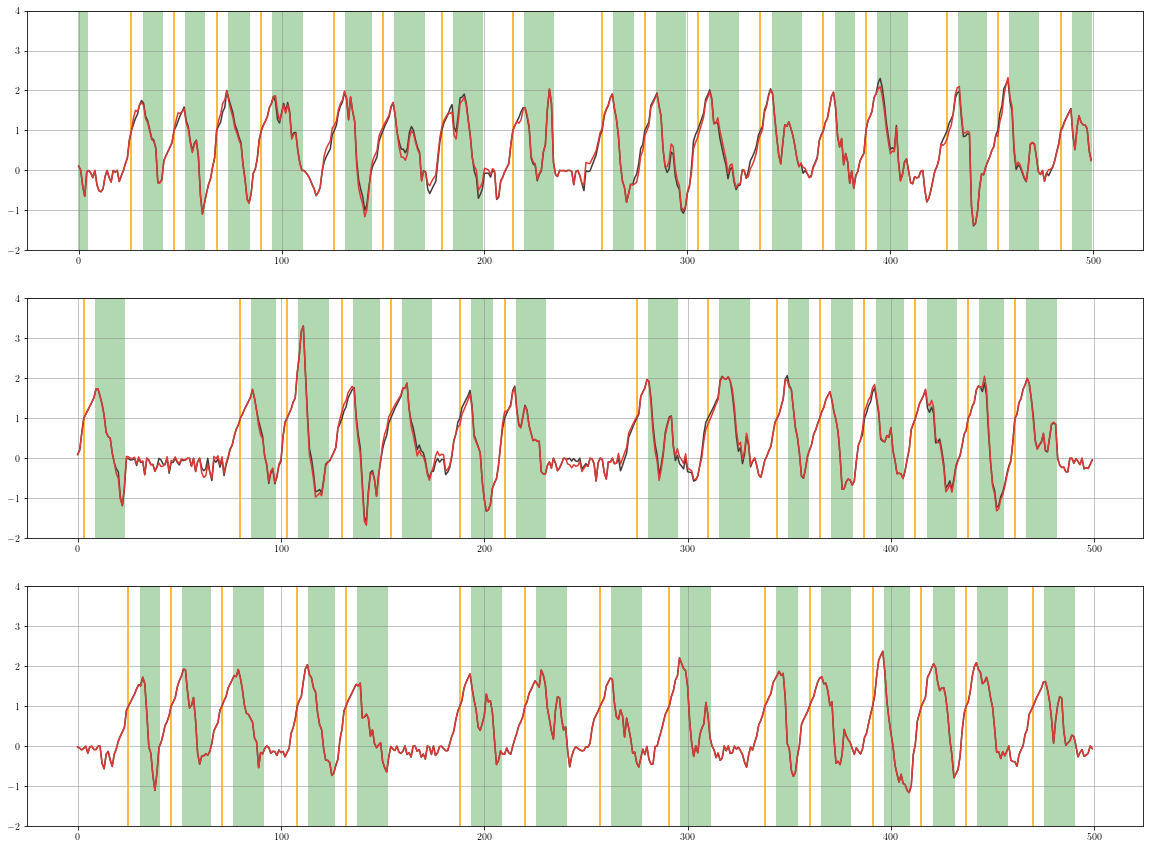

In [21]:
time = torch.arange(N)

fig, axes = plt.subplots(3, figsize=(20, 15))
for l in range(3):
    for n in range(N):
        if mask_at_firing[l,n]:
                axes[l].axvline(n, color="orange")
        if (mask_refractory_period*~mask_around_firing)[l,n]:
            axes[l].add_patch(Rectangle((n-0.5,-2), 1, 6, facecolor="green", alpha=0.3))    
    _ = axes[l].plot(time, y[l])
    _ = axes[l].plot(time, random_y[l])
    _ = axes[l].set_ylim(-2,4)